In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.special import gammaln, digamma
import itertools
from tqdm import tqdm

In [11]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from model.velocity_only.base import *
from model.velocity_only import transition, preference, baseline
from model.helpers import compute_q, compute_sum_kl_div_dirichlet

from plot import plot

In [13]:
transition_velocity_tavv, transition_position_pvp = transition.build()
pref = preference.build()

AssertionError: Sum of transition probabilities is 0

In [14]:
from model.velocity_only.transition import square_exponential_kernel

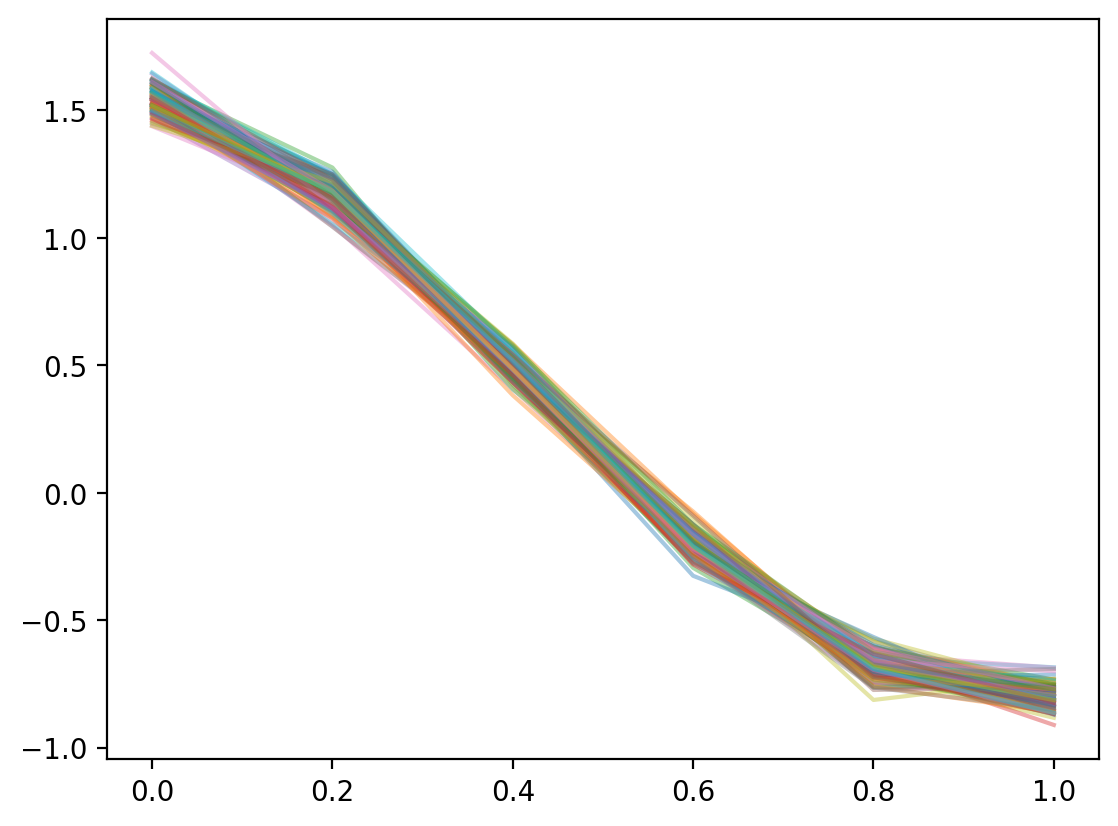

In [15]:
timestep = np.linspace(
    0,
    1.0,
    n_timestep)
mu = 0.4 + 1.2*np.cos(3*(timestep - 2))
alpha = 0.05
length = 0.1
sigma = square_exponential_kernel(timestep, alpha, length)
y = np.random.multivariate_normal(mu, sigma, size=100)
for y_ in y:
    plt.plot(timestep, y_, alpha=0.4)

# Pragmatic values: demonstrate that it works for one timestep

In [7]:
v_idx = 2
pos_idx = 4
t_idx = 3

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.

qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):

    qv_new = qv @ transition_velocity_tavv[t_idx, a, :, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * pref, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for i in range(2):
    e_v[i] = np.average(velocity, weights=transition_velocity_tavv[t_idx, i, v_idx, :])
print("expected velocities", e_v)

pragmatic values [nan nan]
expected velocities [100. 100.]


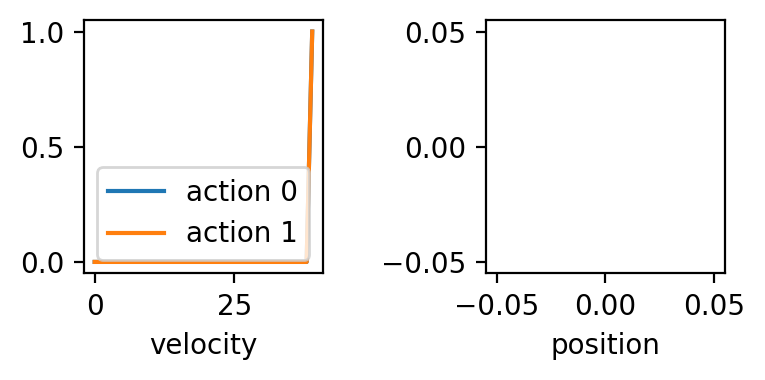

In [8]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [7]:
horizon = 1
n_sample_run = 100

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(1234 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx
                qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ pref)

        a = action_plan[np.argmax(pragmatic)][0]

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tavv[t_idx, a, v_idx, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

run = {
    "policy": "af-pragmatic", 
    "position": hist_pos, 
    "velocity": hist_vel
}

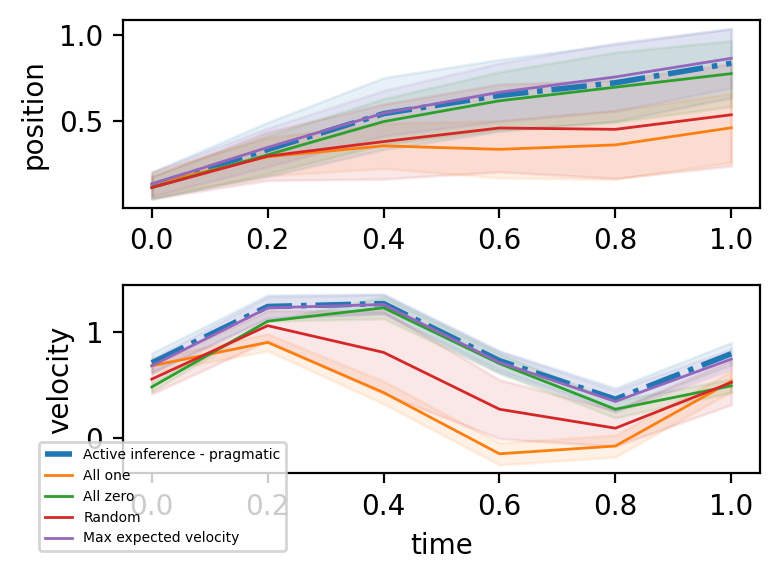

In [8]:
baselines = baseline.run(
    transition_velocity_tavv=transition_velocity_tavv, 
    transition_position_pvp=transition_position_pvp)
plot.runs(run, *baselines)

# Epistemic value

### Learning the model (= inferring the transition) using a RANDOM policy

In [9]:
all_hist_err = {}
policies_err = []

In [10]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
        print(f"Initial error {error:.2f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(
                np.arange(n_velocity), 
                p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.2f}")

run_random = {"policy": "random", "error": hist_err}

Initial error 428.87
[Sample 0] Error after 1200 epochs 352.59
[Sample 1] Error after 1200 epochs 351.68
[Sample 2] Error after 1200 epochs 352.68
[Sample 3] Error after 1200 epochs 350.52
[Sample 4] Error after 1200 epochs 345.10
[Sample 5] Error after 1200 epochs 347.41
[Sample 6] Error after 1200 epochs 347.62
[Sample 7] Error after 1200 epochs 343.30
[Sample 8] Error after 1200 epochs 340.34
[Sample 9] Error after 1200 epochs 346.58
[Sample 10] Error after 1200 epochs 345.29
[Sample 11] Error after 1200 epochs 348.94
[Sample 12] Error after 1200 epochs 347.67
[Sample 13] Error after 1200 epochs 346.23
[Sample 14] Error after 1200 epochs 348.89
[Sample 15] Error after 1200 epochs 350.00
[Sample 16] Error after 1200 epochs 352.35
[Sample 17] Error after 1200 epochs 349.29
[Sample 18] Error after 1200 epochs 347.74
[Sample 19] Error after 1200 epochs 350.75


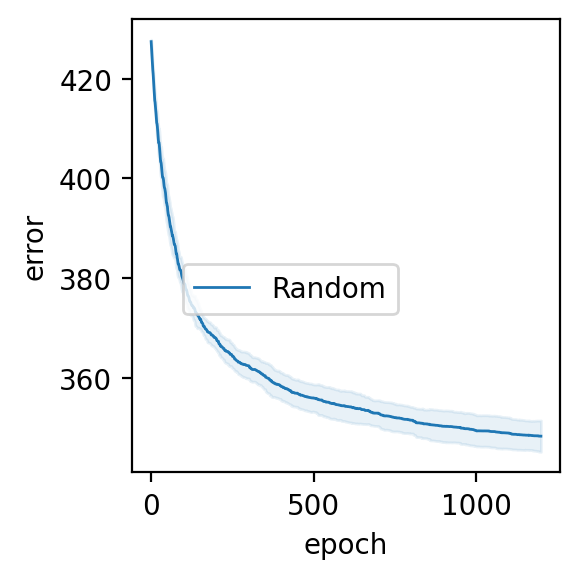

In [11]:
plot.error(run_random)

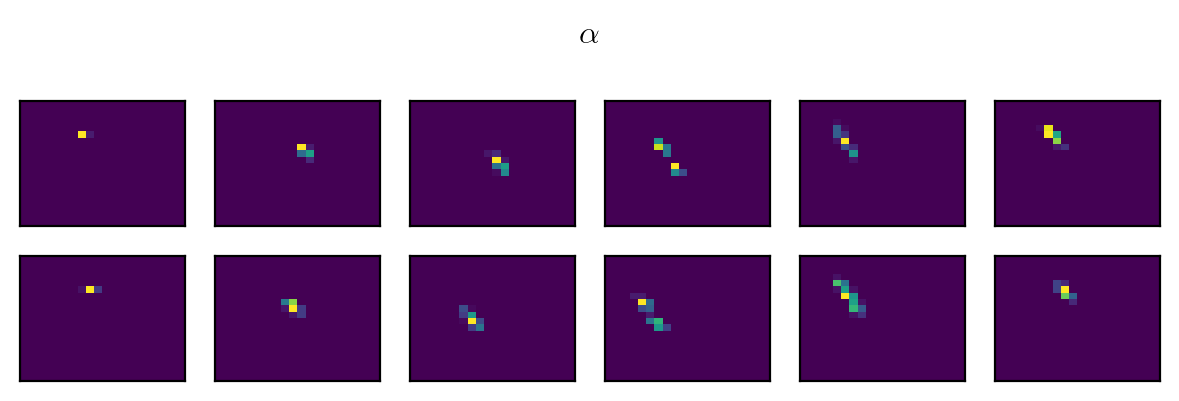

In [12]:
plot.q(alpha_tavv, title=r"$\alpha$")

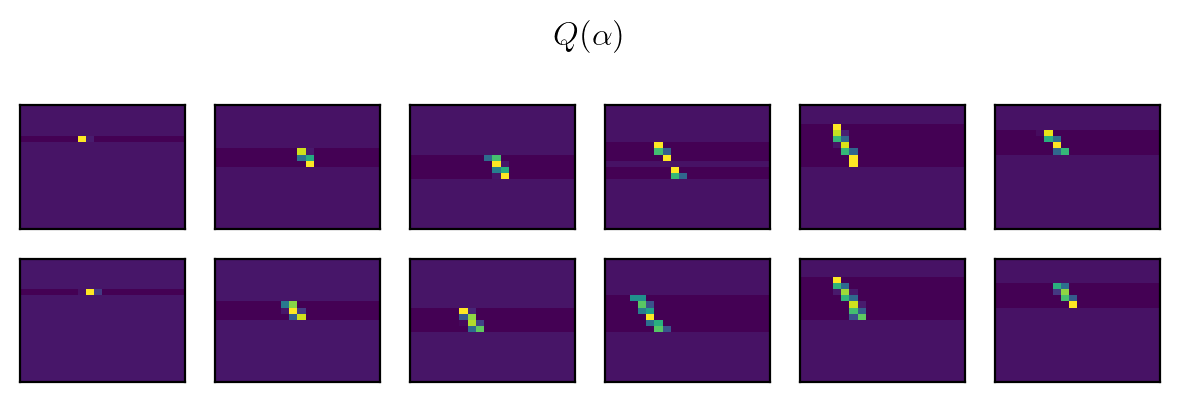

In [13]:
q = compute_q(alpha_tavv)
plot.q(q, title=r"$Q(\alpha)$")

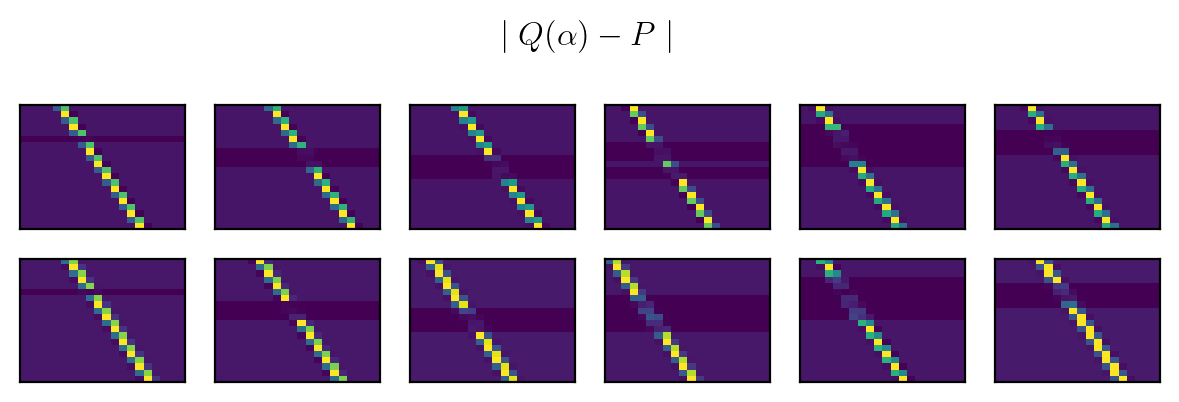

In [14]:
q = compute_q(alpha_tavv)
diff = np.absolute(transition_velocity_tavv - q)
plot.q(diff, title=r"$\mid Q(\alpha) - P \mid$")

In [15]:
n_episode = 200
n_sample_run = 20
horizon = 1  # len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx, t in enumerate(timestep):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            qt = compute_q(alpha_tavv)

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    
                    _qt = qt[rollout_t_index, a]
                    
                    qv = qv @ _qt
                    # qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    make_sense = _qt > 0
                    _qt += 1e-16
                    w = 1/(2*_qt) - 1/(2*np.sum(_qt, axis=-1, keepdims=True))  
                    w = w * make_sense.astype(float)
                    # E_Q[D_KL(Q(o) || Q(o|o'))]
                    v_model = (previous_qv@w)@qv 
                    # v_model /= 10**9
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i))
                    # Because the likelihood is trivial, Q(o) = Q(s)
                    # For a justification of the epistemic value for state, see p 137
                    v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                    v_state_v = - qv @ np.log(qv + 1e-16)
                    
                    # if h_idx == h-1:
                    epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                ## Eq B.28
                ## pragmatic[ap_index] = np.sum(qps @ pref)
                
            # Choose the best action plan
            # Use np.allclose instead of == 
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)
            
    # print(f"[Sample {sample}] plan {ap} t {h_idx} action {a} v_model {v_model:.2f} v_state_p {v_state_p:.2f} v_state_v {v_state_v:.2f}")

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af_epistemic = {"policy": "af-epistemic", "error": hist_err}

Initial error 428.87
[Sample 0] Error after 1200 epochs: 348.29
[Sample 0] Freq choose action 0: 31.33%
[Sample 1] Error after 1200 epochs: 350.20
[Sample 1] Freq choose action 0: 30.33%
[Sample 2] Error after 1200 epochs: 351.05
[Sample 2] Freq choose action 0: 32.50%
[Sample 3] Error after 1200 epochs: 340.78
[Sample 3] Freq choose action 0: 42.50%
[Sample 4] Error after 1200 epochs: 342.32
[Sample 4] Freq choose action 0: 36.42%
[Sample 5] Error after 1200 epochs: 351.44
[Sample 5] Freq choose action 0: 39.58%
[Sample 6] Error after 1200 epochs: 349.15
[Sample 6] Freq choose action 0: 33.75%
[Sample 7] Error after 1200 epochs: 346.67
[Sample 7] Freq choose action 0: 36.33%
[Sample 8] Error after 1200 epochs: 345.99
[Sample 8] Freq choose action 0: 36.17%
[Sample 9] Error after 1200 epochs: 347.57
[Sample 9] Freq choose action 0: 50.17%
[Sample 10] Error after 1200 epochs: 350.20
[Sample 10] Freq choose action 0: 36.42%
[Sample 11] Error after 1200 epochs: 351.16
[Sample 11] Freq cho

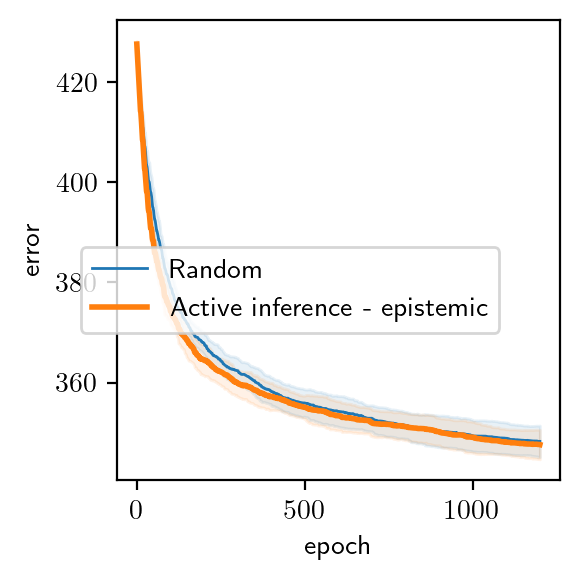

In [16]:
plot.error(run_random, run_af_epistemic)

# All together

In [21]:
n_episode = 500
n_sample_run = 20
horizon = 6  # len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx, t in enumerate(timestep):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            qt = compute_q(alpha_tavv)

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    
                    _qt = qt[rollout_t_index, a]
                    
                    qv = qv @ _qt
                    # qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    make_sense = _qt > 0
                    _qt += 1e-16
                    w = 1/(2*_qt) - 1/(2*np.sum(_qt, axis=-1, keepdims=True))  
                    w = w * make_sense.astype(float)
                    # E_Q[D_KL(Q(o) || Q(o|o'))]
                    v_model = (previous_qv@w)@qv 
                    # v_model /= 10**9
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i))
                    # Because the likelihood is trivial, Q(o) = Q(s)
                    # For a justification of the epistemic value for state, see p 137
                    # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                    # v_state_v = - qv @ np.log(qv + 1e-16)
                    
                    # if h_idx == h-1:
                    epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                # Eq B.28
                pragmatic[ap_index] = np.sum(qps @ pref)
                
            # Choose the best action plan
            # Use np.allclose instead of == 
            efe = epistemic + pragmatic
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[np.isclose(efe, efe.max(), atol=1e-8, rtol=1e-8)])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            hist_pos[sample, t_idx] = position[pos_idx]  # Only the position the last episode will be kept
            hist_vel[sample, t_idx] = velocity[v_idx]    # Only the velocity the last episode will be kept
            hist_a.append(a)
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)
            
    # print(f"[Sample {sample}] plan {ap} t {h_idx} action {a} v_model {v_model:.2f} v_state_p {v_state_p:.2f} v_state_v {v_state_v:.2f}")

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af = {"policy": "af", "error": hist_err, "position": hist_pos, "velocity": hist_vel}

Initial error 428.87
[Sample 0] Error after 3000 epochs: 363.57
[Sample 0] Freq choose action 0: 67.07%
[Sample 1] Error after 3000 epochs: 372.89
[Sample 1] Freq choose action 0: 74.63%
[Sample 2] Error after 3000 epochs: 367.19
[Sample 2] Freq choose action 0: 56.53%
[Sample 3] Error after 3000 epochs: 361.54
[Sample 3] Freq choose action 0: 61.17%
[Sample 4] Error after 3000 epochs: 373.72
[Sample 4] Freq choose action 0: 70.97%
[Sample 5] Error after 3000 epochs: 377.61
[Sample 5] Freq choose action 0: 55.87%
[Sample 6] Error after 3000 epochs: 363.54
[Sample 6] Freq choose action 0: 55.47%
[Sample 7] Error after 3000 epochs: 386.67
[Sample 7] Freq choose action 0: 68.70%
[Sample 8] Error after 3000 epochs: 368.22
[Sample 8] Freq choose action 0: 84.33%
[Sample 9] Error after 3000 epochs: 373.94
[Sample 9] Freq choose action 0: 54.37%
[Sample 10] Error after 3000 epochs: 366.76
[Sample 10] Freq choose action 0: 57.17%
[Sample 11] Error after 3000 epochs: 364.07
[Sample 11] Freq cho

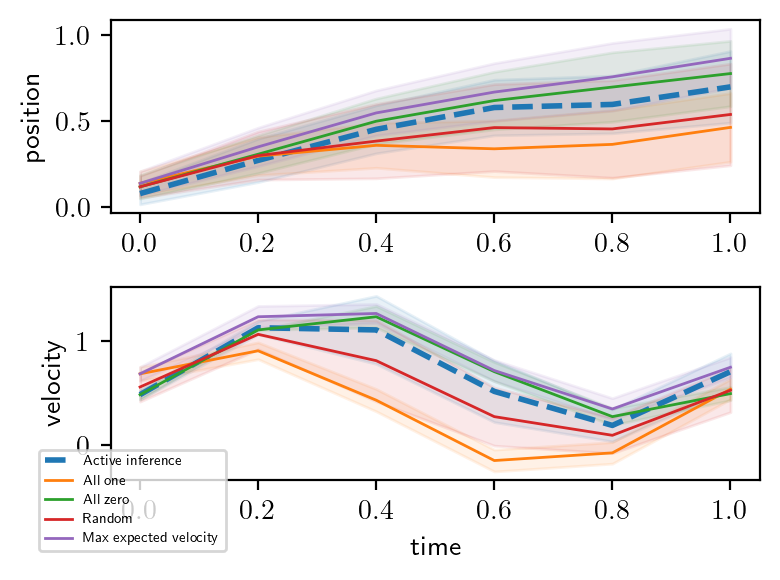

In [22]:
plot.runs(run_af, *baselines)

# Possible extensions

    - Always using a fix horizon (modulo the beginning of the episode)
    - Pretraining the model
    - Using a couple of different generative models
    - Add meaninful priors (e.g. night)
    - Add the current position as a predictor of the velocity

In [ ]:
    # # ---- Pre-training ----
    #
    # epoch = 0
    # for idx_ep in tqdm(range(n_episode_pre_train)):
    #
    #     np.random.seed(12334 + idx_ep)
    #
    #     pos_idx = np.absolute(position).argmin()  # Something close to 0
    #     v_idx = np.absolute(velocity).argmin() # Something close to 0
    #
    #     action_plan = np.random.randint(n_action, size=n_timestep)
    #
    #     for ap_index in range(len(action_plan)):
    #
    #         a = action_plan[t_idx]
    #         new_v_index = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])
    #
    #         # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
    #         alpha_tvav[t_idx, v_idx, a, new_v_index] += 1
    #
    #         # print("v_idx", v_idx, "new_v_index", new_v_index)
    #
    #         # Update velocity and position
    #         v_idx = new_v_index
    #         pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])
    #
    #         # Log
    #         error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
    #         hist_err.append(error)
    #         epoch += 1

    # print(f"Error after {epoch} epochs, before learning: {error}")